## PU Learning For News
Initial work

Mainly to start exploring how to vectorize texts and also identify true negatives

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

# nltk.download('punkt')
# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\atin3\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\atin3\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\atin3\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
from sklearn.utils import resample

input_file = "./article_dataset.csv"
df_raw = pd.read_csv(input_file, index_col="id")
df_raw = preprocessing.clean_df(df_raw)
df_raw = df_raw[df_raw['cleaned_text'].str.strip() != ""].copy()
df_raw.reset_index(inplace=True)
df_raw['id'] = df_raw.index
df_raw["clean_title"] = df_raw['title'].apply(preprocessing.clean_text)

df = df_raw.copy()
df = preprocessing.turn_into_pu(df, 0.5)

X_train, X_test, y_train, y_test = preprocessing.test_train_split(df)
y_train.index = X_train.index
y_test_true = df_raw.loc[y_test.index, 'label']

X_train_bootstrap, y_train_bootstrap = resample(
    X_train, y_train,
    replace=True,
    n_samples=len(X_train),
    random_state=42
)
X_train, y_train = X_train_bootstrap, y_train_bootstrap

X_train['tokens'] = X_train['cleaned_text'].apply(lambda x: x.split())
df.head()

,id,title,author,text,label,cleaned_text,clean_title
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide didnt even see comeys letter ja...,house dem aide didnt even see comeys letter ja...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,ever get feeling life circle roundabout rather...,flynn hillary clinton big woman campus breitbart
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,truth might get fired october tension intellig...,truth might get fired
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,video civilian killed single u airstrike ident...,civilian killed single u airstrike identified
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,print iranian woman sentenced six year prison ...,iranian woman jailed fictional unpublished sto...


## Vectorizing Text
TF-IDF words

In [8]:
import time

start_time = time.time()

vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(), lowercase=True)
tfidf_matrix = vectorizer.fit_transform(X_train['cleaned_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=X_train.index)

pca_logistic = PCA(n_components=6)
principal_components_logistic = pca_logistic.fit_transform(tfidf_df)
print("Explained Variance: ", pca_logistic.explained_variance_ratio_.cumsum())
end_time = time.time()
print("Time elapsed: {:.2f} seconds".format(end_time - start_time))

pca_svm = PCA(n_components=30)
principal_components_svm = pca_svm.fit_transform(tfidf_df)
print("Explained Variance: ", pca_svm.explained_variance_ratio_.cumsum())

end_time = time.time()
print("Time elapsed: {:.2f} seconds".format(end_time - start_time))

C:\Users\atin3\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Explained Variance:  [0.01367917 0.02235335 0.02860911 0.03448028 0.03940357 0.04338159]
Time elapsed: 254.11 seconds
Explained Variance:  [0.01367917 0.02235335 0.02860911 0.03448028 0.03940363 0.0433828
 0.04717504 0.05065785 0.0538754  0.05682713 0.05948698 0.06209655
 0.06463824 0.06711149 0.06955993 0.07194289 0.07418611 0.07634686
 0.07844643 0.08047327 0.08240216 0.08429703 0.08618565 0.08800001
 0.08977545 0.09149533 0.09320106 0.0948481  0.09645029 0.09802663]
Time elapsed: 575.50 seconds


### Vectorizing through Document Content

In [10]:
start_time = time.time()

analyzer = SentimentIntensityAnalyzer()
def sentiment_maker(df: pd.DataFrame, type:str):
    df['sentiment'] = df[type].apply(analyzer.polarity_scores)
    df = pd.concat([df.drop(['sentiment'], axis=1), df['sentiment'].apply(pd.Series)], axis=1)
    df.rename(columns={col: f"{col}_{type}" for col in ["pos", "neu", "neg"]}, inplace=True)
    return df

def count_stop_words(tokens):
    stop_word_count = sum(1 for word in tokens if word in stop_words)
    return stop_word_count / len(tokens)

X_vec = X_train.copy()
X_vec['len'] = X_vec['tokens'].apply(lambda x: len(x))

X_vec = sentiment_maker(X_vec, "cleaned_text")
X_vec = sentiment_maker(X_vec, "clean_title")

X_vec['percent_stop'] = X_vec['tokens'].apply(count_stop_words)
X_vec
end_time = time.time()
print("Time elapsed: {:.2f} seconds".format(end_time - start_time))

Time elapsed: 449.32 seconds


In [12]:
def get_train_combined(X_vec, principal_components):
    X_vec_numeric = X_vec.select_dtypes(include=np.number).drop(columns=["id"])
    principal_components_df = pd.DataFrame(principal_components)
    temp_index = X_vec.index
    X_vec_numeric.reset_index(inplace=True)
    principal_components_df.reset_index(inplace=True)
    x_train_combined = pd.concat([X_vec_numeric, principal_components_df], axis=1)
    x_train_combined.drop(columns=['index'], inplace=True)
    x_train_combined.set_index(temp_index, inplace=True)
    x_train_combined.columns = x_train_combined.columns.astype(str)
    return x_train_combined

x_train_combined_logistic = get_train_combined(X_vec, principal_components_logistic)
x_train_combined_svm = get_train_combined(X_vec, principal_components_svm)

### Preprocessing

In [42]:
### Preprocessing X test
## Same preprocessing X train went through
## Utilizing fitted pca and tfidf
test_tfidf_matrix = vectorizer.transform(X_test['cleaned_text'])

test_tfidf = pd.DataFrame(test_tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=X_test.index)
test_pca_logistic = pd.DataFrame(pca_logistic.transform(test_tfidf))
test_pca_svm = pd.DataFrame(pca_svm.transform(test_tfidf))

X_test_vec = X_test.copy()
X_test_vec['tokens'] = X_test_vec['cleaned_text'].apply(lambda x: x.split())
X_test_vec['len'] = X_test_vec['tokens'].apply(lambda x: len(x))
X_test_vec = sentiment_maker(X_test_vec, "cleaned_text")
X_test_vec = sentiment_maker(X_test_vec, "clean_title")
X_test_vec['percent_stop'] = X_test_vec['tokens'].apply(count_stop_words)

X_vec_numeric = X_test_vec.select_dtypes(include=np.number).drop(columns=["id"])
x_test_index = X_test.index
X_vec_numeric.reset_index(inplace=True)
test_pca_logistic.reset_index(inplace=True)
test_pca_svm.reset_index(inplace=True)

x_test_processed_logistic = pd.concat([X_vec_numeric, test_pca_logistic], axis=1)
x_test_processed_logistic.set_index(x_test_index, inplace=True)
x_test_processed_logistic.columns = x_test_processed_logistic.columns.astype(str)
x_test_processed_logistic.drop(columns=['index'], inplace=True)

x_test_processed_svm = pd.concat([X_vec_numeric, test_pca_svm], axis=1)
x_test_processed_svm.set_index(x_test_index, inplace=True)
x_test_processed_svm.columns = x_test_processed_svm.columns.astype(str)
x_test_processed_svm.drop(columns=['index'], inplace=True)

### Hyper-parmeter tuning for logistic regression

In [16]:
logit = LogisticRegression()
from sklearn.model_selection import GridSearchCV

param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100, 1000],
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [1000,2500, 5000]
    }
]

clf = GridSearchCV(logit, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
best_clf = clf.fit(x_train_combined_logistic,y_train)

Fitting 3 folds for each of 660 candidates, totalling 1980 fits


C:\Users\atin3\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
891 fits failed out of a total of 1980.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
99 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\atin3\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\atin3\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\atin3\anaconda3\Lib\site-packages\sklearn\linear_model\

### Creating Logistic Regression Model
Model trained on PU data\
Confusion Matrix based on true values of y

C:\Users\atin3\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


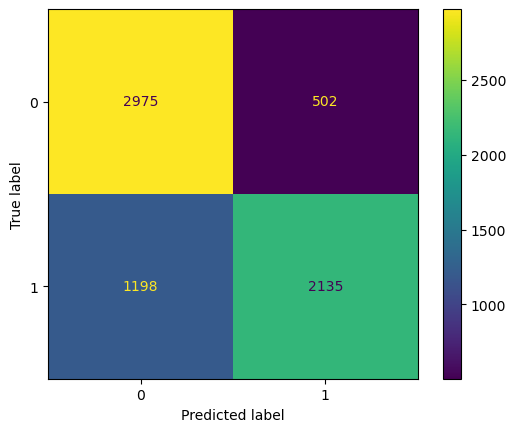

In [18]:
## Making Model
logreg = LogisticRegression(random_state=97)
logreg.fit(x_train_combined_logistic, y_train)

y_pred_proba = logreg.predict_proba(x_test_processed_logistic)
y_pred_logistic = [1 if proba[1] > 0.8 else 0 for proba in y_pred_proba]
confusion_matrix = metrics.confusion_matrix(y_test_true, y_pred_logistic)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

### SVM

In [44]:
x_test_processed_svm

,len,neg_cleaned_text,neu_cleaned_text,pos_cleaned_text,compound,neg_clean_title,neu_clean_title,pos_clean_title,compound,percent_stop,...,20,21,22,23,24,25,26,27,28,29
17038,125,0.071,0.871,0.057,-0.4348,0.000,1.000,0.000,0.0000,0.000000,...,-0.020961,-0.055251,-0.007201,0.038184,-0.005241,-0.033393,0.009406,-0.014820,0.004429,-0.002115
7623,529,0.047,0.781,0.172,0.9965,0.000,0.777,0.223,0.3182,0.015123,...,-0.024423,0.060845,0.030136,-0.046778,-0.078419,0.084837,0.036675,0.021714,-0.047267,-0.024534
1647,742,0.196,0.706,0.097,-0.9981,0.000,1.000,0.000,0.0000,0.000000,...,0.018115,0.014276,0.026971,0.003505,-0.061707,-0.064360,0.007998,-0.048074,-0.105336,0.190910
4727,675,0.137,0.742,0.122,-0.9646,0.248,0.537,0.215,-0.1280,0.002963,...,0.004409,-0.050312,-0.001253,0.037205,0.000113,-0.014762,-0.011616,-0.032474,0.007357,-0.036927
13379,392,0.036,0.773,0.191,0.9958,0.000,1.000,0.000,0.0000,0.005102,...,-0.049265,-0.021509,-0.073598,-0.011675,-0.023894,-0.000103,-0.059913,-0.034842,0.064052,0.074590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8325,362,0.041,0.719,0.240,0.9979,0.000,0.795,0.205,0.2023,0.005525,...,0.031509,-0.019638,0.004429,0.030320,-0.000383,-0.013876,0.029988,-0.013807,-0.007683,0.009496
8973,460,0.200,0.701,0.099,-0.9968,0.301,0.699,0.000,-0.6486,0.000000,...,-0.008623,-0.023980,-0.020179,0.011508,-0.010571,-0.004374,0.004292,-0.013622,-0.005086,-0.021405
6242,126,0.109,0.709,0.182,0.8470,0.000,1.000,0.000,0.0000,0.007937,...,0.018723,0.016838,-0.009732,-0.004647,0.007412,0.005370,-0.017697,-0.022624,0.035041,0.019419
9319,161,0.212,0.737,0.051,-0.9806,0.273,0.727,0.000,-0.6705,0.000000,...,0.054544,0.031841,0.032703,-0.028751,-0.018230,-0.021746,-0.018346,-0.029811,-0.001469,0.000547


In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_combined_svm)
x_test_scaled = scaler.transform(x_test_processed_svm)
svm = SVC(kernel="linear", C=1.0, gamma="scale", probability=True, random_state=100)
svm.fit(x_train_scaled, y_train)

# y_pred = svm.predict(x_test_scaled)
y_probs = svm.predict_proba(x_test_scaled)[:,1]

In [49]:
from sklearn.metrics import classification_report, accuracy_score

threshold = 0.8
y_pred_svm = (y_probs >= threshold).astype(int)

accuracy = accuracy_score(y_test_true, y_pred_svm)

print(f"Evaluation at Threshold: {threshold}")
print(f" Accuracy: {accuracy:.3f}")
print(classification_report(y_test_true, y_pred_svm))
print("y_test distribution:", np.bincount(y_test_true))
print("y_pred distribution:", np.bincount(y_pred_svm))

Evaluation at Threshold: 0.8
 Accuracy: 0.818
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      3477
           1       0.82      0.80      0.81      3333

    accuracy                           0.82      6810
   macro avg       0.82      0.82      0.82      6810
weighted avg       0.82      0.82      0.82      6810

y_test distribution: [3477 3333]
y_pred distribution: [3559 3251]


### Naive Bayes

In [51]:
X_test['tokens'] = X_test['cleaned_text'].apply(lambda x: x.split())
x_test_combined = sentiment_maker(X_test, "cleaned_text")
x_test_combined = sentiment_maker(x_test_combined, "clean_title")
x_test_combined['percent_stop'] = x_test_combined['tokens'].apply(count_stop_words)
x_test_combined

,id,title,author,text,cleaned_text,clean_title,tokens,neg_cleaned_text,neu_cleaned_text,pos_cleaned_text,compound,neg_clean_title,neu_clean_title,pos_clean_title,compound,percent_stop
17038,17038,McCain: ‘I Don’t Know’ If Trump-Russia Dossier...,Pam Key,Wednesday on CNN addressing media reports that...,wednesday cnn addressing medium report turned ...,mccain dont know trumprussia dossier credible ...,"[wednesday, cnn, addressing, medium, report, t...",0.071,0.871,0.057,-0.4348,0.000,1.000,0.000,0.0000,0.000000
7623,7623,Netflix Casts a Wider Net for Original Documen...,Glenn Kenny,"It was early in March 2015, the filmmaker Ava ...",early march filmmaker ava duvernay recalled re...,netflix cast wider net original documentary ne...,"[early, march, filmmaker, ava, duvernay, recal...",0.047,0.781,0.172,0.9965,0.000,0.777,0.223,0.3182,0.015123
1647,1647,"Aleppo Evacuation Effort Restarts, and Assad C...",Ben Hubbard and Hwaida Saad,"BEIRUT, Lebanon — After months of fierce bo...",beirut lebanon month fierce bombardment failed...,aleppo evacuation effort restarts assad call h...,"[beirut, lebanon, month, fierce, bombardment, ...",0.196,0.706,0.097,-0.9981,0.000,1.000,0.000,0.0000,0.000000
4727,4727,Friends Say Minnesota Attacker Was ‘Normal Ame...,Mitch Smith and Richard Pérez-Peña,"ST. CLOUD, Minn. — The man who the police s...",st cloud minn man police say stabbed people ma...,friend say minnesota attacker normal american ...,"[st, cloud, minn, man, police, say, stabbed, p...",0.137,0.742,0.122,-0.9646,0.248,0.537,0.215,-0.1280,0.002963
13379,13379,Nearly Four-Fifths of White Evangelicals Say T...,Laurie Goodstein,Nearly of white evangelical voters plan to c...,nearly white evangelical voter plan cast ballo...,nearly fourfifths white evangelicals say theyl...,"[nearly, white, evangelical, voter, plan, cast...",0.036,0.773,0.191,0.9958,0.000,1.000,0.000,0.0000,0.005102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8325,8325,When a Basic Laptop Will Do: Our Top Budget Pi...,Damon Darlin,"Ever since the advent of the iPhone and iPad, ...",ever since advent iphone ipad people using lap...,basic laptop top budget pick new york time,"[ever, since, advent, iphone, ipad, people, us...",0.041,0.719,0.240,0.9979,0.000,0.795,0.205,0.2023,0.005525
8973,8973,Leader of a Ku Klux Klan Group Is Found Dead i...,Liam Stack,"Frank Ancona, the professed leader of the Trad...",frank ancona professed leader traditionalist a...,leader ku klux klan group found dead missouri ...,"[frank, ancona, professed, leader, traditional...",0.200,0.701,0.099,-0.9968,0.301,0.699,0.000,-0.6486,0.000000
6242,6242,Economic Breadth Is Significantly Deterioratin...,IWB,Economic Breadth Is Significantly Deterioratin...,economic breadth significantly deteriorating u...,economic breadth significantly deteriorating u,"[economic, breadth, significantly, deteriorati...",0.109,0.709,0.182,0.8470,0.000,1.000,0.000,0.0000,0.007937
9319,9319,Keith Lamont Scott Was Killed by Two Gunshot W...,Niraj Chokshi,A black man whose fatal shooting by the pol...,black man whose fatal shooting police septembe...,keith lamont scott killed two gunshot wound fa...,"[black, man, whose, fatal, shooting, police, s...",0.212,0.737,0.051,-0.9806,0.273,0.727,0.000,-0.6705,0.000000


In [53]:
from scipy.sparse import hstack

vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(), lowercase=True)
tfidf_matrix = vectorizer.fit_transform(X_train['cleaned_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=X_train.index)
X_test_tfidf = vectorizer.transform(X_test['cleaned_text'])

# Extract numerical sentiment & stop-word features
X_train_extra = np.array(X_vec[["pos_cleaned_text", "neu_cleaned_text", "neg_cleaned_text", "percent_stop"]])
X_test_extra = np.array(x_test_combined[["pos_cleaned_text", "neu_cleaned_text", "neg_cleaned_text", "percent_stop"]])

# Stack TF-IDF matrix with additional features
X_train_final = hstack([tfidf_matrix, X_train_extra])
X_test_final = hstack([X_test_tfidf, X_test_extra])
X_train_final

C:\Users\atin3\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<13826x104134 sparse matrix of type '<class 'numpy.float64'>'
	with 3673094 stored elements in COOrdinate format>

In [55]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB


from sklearn.metrics import classification_report, accuracy_score
# Predict on test set
model = BernoulliNB()
model.fit(X_train_final, y_train)
y_pred_nb = model.predict(X_test_final)

# Print evaluation results
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))
print("y_test distribution:", np.bincount(y_test))
print("y_pred distribution:", np.bincount(y_pred_nb))

Accuracy: 0.708223201174743
              precision    recall  f1-score   support

           0       0.43      0.48      0.45      1714
           1       0.82      0.78      0.80      5096

    accuracy                           0.71      6810
   macro avg       0.62      0.63      0.63      6810
weighted avg       0.72      0.71      0.71      6810

y_test distribution: [1714 5096]
y_pred distribution: [1925 4885]


### Ensemble Learning(Bagging)

In [67]:
import numpy as np
from scipy.stats import mode

predictions = np.vstack((y_pred_logistic, y_pred_svm, y_pred_nb))

majority_vote = mode(predictions, axis=0).mode[0]

print("Accuracy:", accuracy_score(y_test, majority_vote))
print(classification_report(y_test, majority_vote))
print("y_test distribution:", np.bincount(y_test))
print("y_pred distribution:", np.bincount(majority_vote))

C:\Users\atin3\AppData\Local\Temp\ipykernel_14140\3812275071.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  majority_vote = mode(predictions, axis=0).mode[0]


Accuracy: 0.6807635829662262
              precision    recall  f1-score   support

           0       0.43      0.79      0.56      1714
           1       0.90      0.64      0.75      5096

    accuracy                           0.68      6810
   macro avg       0.66      0.72      0.65      6810
weighted avg       0.78      0.68      0.70      6810

y_test distribution: [1714 5096]
y_pred distribution: [3172 3638]
